In [1]:
import numpy as np
import cv2
from PIL import Image
import open3d as o3d
import json
import os
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
from shapely.geometry import MultiPoint, box

# from pyquaternion.quaternion import Quaternion
from pyquaternion import Quaternion
import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.geometry_utils import view_points, BoxVisibility
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.scripts.export_2d_annotations_as_json import get_2d_boxes, post_process_coords
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from vis_utils import plot_3d_image_
from utils import *

from typing import Tuple, List, Dict, Union

%matplotlib inline

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.7 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Loop to create the features and targets file

In [6]:
# path with all the sample files
samples_path =  os.getcwd() + '/dataset/samples/'

# path to retrieve point clous features
features_path =  os.getcwd() + '/dataset/point_features_path/'

# Matrix to store the features' vectors
features_matrix = []
# Dictionary of targets
targets_dic = {'x_pos': [], 'y_pos': [], 'z_pos': [], 'width': [], 'lenght': [], 'height': [], 'yaw': []}

tokens_dic = {'sample_token': [], 'camera_token': [], 'category': []}

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):    
        
        # load the current sample file
        data_json = load_file(samples_path + file_)
                
        # process each instance
        for idx in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][idx]

            # Retrieve instance's features
            features_vec = parse_features_to_numpy(annotation_metadata['point_features_path'])
            
            # Store the current feature vector in the features' matrix
            features_matrix.append(list(features_vec))
            
            # Extract class targets
            pose = annotation_metadata['position_coord']
            dims = annotation_metadata['wlh_values']
            yaw = annotation_metadata['orientation_value']
            label = annotation_metadata['category']
            
            # Save X, Y and Z pose
            targets_dic['x_pos'].append(pose[0])
            targets_dic['y_pos'].append(pose[1])
            targets_dic['z_pos'].append(pose[2])
            
            # Store target size
            targets_dic['width'].append(dims[0])
            targets_dic['lenght'].append(dims[1])
            targets_dic['height'].append(dims[2])
            
            # Save the orientations in such way that the rotation matrix is always 1
            if annotation_metadata['rotation_axis'] > 0:
                # Store target orientation
                targets_dic['yaw'].append(yaw)
            else:
                targets_dic['yaw'].append(-yaw)
                
            
            # Store sample, camera and annotation token
            tokens_dic['sample_token'].append(annotation_metadata['sample_token'])
            tokens_dic['camera_token'].append(annotation_metadata['camera_token'])
            tokens_dic['category'].append(annotation_metadata['category'])

            
# Parse features as a numpy array
features_matrix = np.array(features_matrix)

# Create a dataframe of features
df_features = pd.DataFrame(data = features_matrix)
# Create a dataframe of targets
df_targets = pd.DataFrame.from_dict(targets_dic)
# Create a dataframe of tokens
df_tokens = pd.DataFrame.from_dict(tokens_dic)

# Concat both dataframes horizontally to create the final dataframe
df_detection = pd.concat([df_features, df_targets, df_tokens], axis=1)
df_detection.head()

df_detection.to_csv('dataset/3d_obj_detection.csv')

annotation_metadata

Sample files: 100%|██████████| 404/404 [00:00<00:00, 741.46it/s]


{'annotation_token': 'd8fcbd175ff64c71a26eb8eefe50a909',
 'sample_token': '23799328f65843fc9e0c71f2bfbe90ef',
 'camera_token': '75ff6b54dd154fe5a3a450e8ab79d006',
 'pointcloud_path': '/home/sherlock/Documents/3d_obj_detection/dataset/ann_points_lidar/pc_anno_d8fcbd175ff64c71a26eb8eefe50a909.txt',
 'pcl_shape': [3, 1069],
 'img_pc_path': '/home/sherlock/Documents/3d_obj_detection/dataset/ann_points_cam/img_pc_anno_d8fcbd175ff64c71a26eb8eefe50a909.txt',
 'img_pcl_shape': [4, 1069],
 'pcd_path': '/home/sherlock/Documents/3d_obj_detection/dataset/pcd_segmentation/pcd_segmentation_d8fcbd175ff64c71a26eb8eefe50a909.pcd',
 'point_features_path': '/home/sherlock/Documents/3d_obj_detection/dataset/point_features/pcd_segmentation_d8fcbd175ff64c71a26eb8eefe50a909.txt',
 'position_coord': [-8.01931192409964,
  -0.5337671004285317,
  -1.0506086309228753],
 'wlh_values': [1.891, 4.81, 1.873],
 'orientation_value': -89.46685818502475,
 'rotation_axis': 0.9992781194251954,
 'category': 'vehicle'}

## Loading CSV and parsing info as a numpy array

In [14]:
# Load dataframe form CSV file\n",
df_detection_csv = pd.read_csv('dataset/3d_obj_detection.csv')
# features: 1 - 640 // targets: 641 - 648
        
print('The Dataframe shape is {}'.format(df_detection_csv.shape))
print('The targets keys are',df_detection_csv.keys()[641:651])
# Parse features and targets to numpy array\n",
features = df_detection_csv.loc[:,'0':'639'].to_numpy()
targets = df_detection_csv.loc[:,'x_pos':'category']
print('The Features shape is {}'.format(features.shape))
print('The Targets shape is {}'.format(targets.shape))



The Dataframe shape is (1413, 651)
The targets keys are Index(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw',
       'sample_token', 'camera_token', 'category'],
      dtype='object')
The Features shape is (1413, 640)
The Targets shape is (1413, 10)


## Splitting and scaling the data

In [40]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import Normalizer 

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=1)

print('Train set features size: \n {}'.format(X_train.shape))
print('Test set featires size: \n {}'.format(X_test.shape))
print('Train set targets size: \n {}'.format(y_train.shape))
print('Test set targets size: \n {}'.format(y_test.shape))

y_train_tokens = y_train.drop(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw'], axis=1)
y_test_tokens =  y_test.drop(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw'], axis=1)
y_train = y_train.loc[:,'x_pos':'yaw'].to_numpy()
y_test = y_test.loc[:,'x_pos':'yaw'].to_numpy()

# transform orientation from degres to sin + 1 
y_train_yaw = y_train[:, 6]
y_train[:, 6] = (np.sin(np.deg2rad(y_train_yaw))*2)+2

y_test_yaw = y_test[:, 6]
y_test[:, 6] = (np.sin(np.deg2rad(y_test_yaw))*2)+2


Train set features size: 
 (1130, 640)
Test set featires size: 
 (283, 640)
Train set targets size: 
 (1130, 10)
Test set targets size: 
 (283, 10)


## Transformation

In [22]:
scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Multi output regressor Ridge 

In [41]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

clf = MultiOutputRegressor(Ridge(random_state = 123)).fit(X_train_scaled, y_train)

In [42]:
print('Training set score is: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
print('Test set score is: {:.2f}'.format(clf.score(X_test_scaled, y_test)))

Training set score is: 0.62
Test set score is: 0.26


In [46]:
index=60
ridge_pred_train = clf.predict(X_train_scaled)
print('Train prediction: ', ridge_pred_train[index])
print("Train Targets: ", y_train[index] )
# ['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw']

Train prediction:  [ 3.74864197 -0.62542001 -0.47146432  2.39819572  7.76661309  2.74541723
  1.71361948]
Train Targets:  [ 4.37782236e+00  1.07049415e+01 -4.74785905e-01  1.81900000e+00
  4.72700000e+00  2.11200000e+00  6.98010250e-04]


In [45]:
index=60
ridge_pred_test = clf.predict(X_test_scaled)
print('Test prediction: ', ridge_pred_test[index])
print("Test Targets: ", y_test[index] )
# ['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw']

Test prediction:  [ 1.21057094 -2.63099684 -0.78933447  1.97375488  4.97955807  2.04730682
  2.07722854]
Test Targets:  [ 4.38095063 10.5800861  -0.48039748  1.889       4.76        1.531
  3.99975128]


## Multi output regressor SVR¶

In [37]:
from sklearn import svm

clf = MultiOutputRegressor(svm.SVR(kernel='linear')).fit(X_train_scaled, y_train)

print('Training set score is: {:.2f}'.format(clf.score(X_train_scaled, y_train)))
print('Test set score is: {:.2f}'.format(clf.score(X_test_scaled, y_test)))

Training set score is: 0.52
Test set score is: 0.25


In [47]:
index=60
svm_pred_train = clf.predict(X_train_scaled)
print('Train prediction: ', svm_pred_train[index])
print("Train Targets: ", y_train[index] )
# ['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw']

Train prediction:  [ 3.74864197 -0.62542001 -0.47146432  2.39819572  7.76661309  2.74541723
  1.71361948]
Train Targets:  [ 4.37782236e+00  1.07049415e+01 -4.74785905e-01  1.81900000e+00
  4.72700000e+00  2.11200000e+00  6.98010250e-04]


In [48]:
index = 60
svm_pred_test = clf.predict(X_test_scaled)
print('Test prediction: ', svm_pred_test[index])
print("Test Targets: ", y_test[index] )
# ['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw']

Test prediction:  [ 1.21057094 -2.63099684 -0.78933447  1.97375488  4.97955807  2.04730682
  2.07722854]
Test Targets:  [ 4.38095063 10.5800861  -0.48039748  1.889       4.76        1.531
  3.99975128]


## Visualizing 3D plot

In [55]:
# sample index to predict
idx = 954 # Idx 
# Make a prediction
svm_pred_test = clf.predict(X_train_scaled[idx, :].reshape(1, -1))
# Extract relevant info of the prediction
fast_test = y_train_tokens.to_numpy()
sample_token, cam_token, label = fast_test[idx, :]
# Compare ground truth vs prediction\n",
print(svm_pred_test)
print(y_train[idx, :])

[[11.22030368 -8.10328537 -1.29481947  1.94772855  5.1313112   1.62432756
  -0.07518441]]
[ 1.16758926e+01 -2.88495416e+00 -1.27623881e+00  1.74500000e+00
  4.66300000e+00  1.48200000e+00  7.26774544e-03]


In [56]:
# Create a Quaternion with the orientation of the predicted vehicle
# IT HAS TO BE -1
q0 = Quaternion(axis=[0, 0, 1], angle = svm_pred_test[0][6]* np.pi / 180)
# Create the bounding box object
bbox = Box(svm_pred_test[0][:3], svm_pred_test[0][3:6], q0, name = label, 
               token = sample_token)

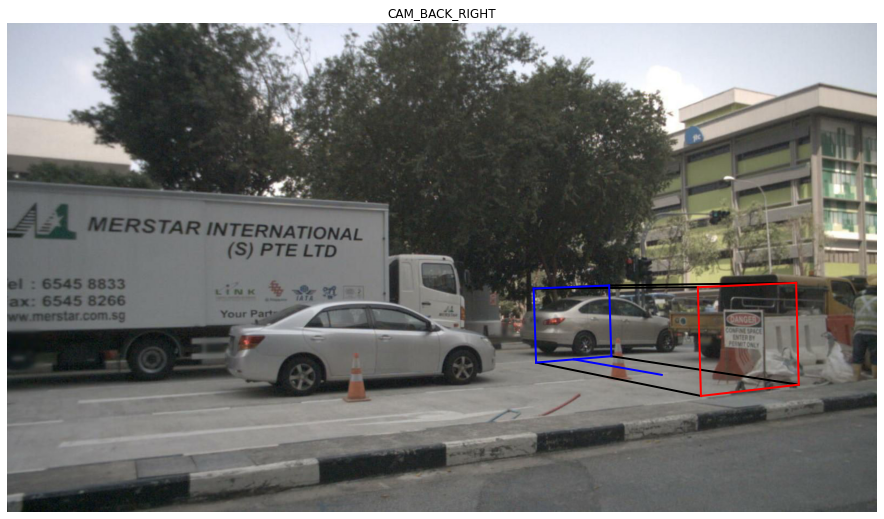

In [57]:
# Plot the results
plot_3d_image_(nusc, cam_token, label, sample_token, bbox)

## MLP Regressor

In [34]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(hidden_layer_sizes=700,random_state=1, max_iter=800).fit(X_train_scaled, y_train)
mlp_reg.n_layers_

3

In [35]:
mlp_pred_test = mlp_reg.predict(X_test_scaled)
print('Test prediction: ', mlp_pred_test[50])
print("Test Targets: ", y_test[50] )
# ['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw']

Test prediction:  [ 15.33210205 -12.50733147  -1.31448692   1.77592799   3.49189837
   1.29828176   0.39715835]
Test Targets:  [ 1.21091483e+01 -6.91652228e+00 -1.13084144e+00  2.12600000e+00
  4.59200000e+00  1.64100000e+00  3.41403508e-05]


---